In [1]:
import pandas as pd


df = pd.read_csv("LECLERC_cleaned.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

distinct_timestamps = df['Timestamp'].drop_duplicates().sort_values()

# 3) Calculer la différence entre chaque timestamp consécutif
time_diffs = distinct_timestamps.diff().dropna()  # la première différence est NaT

# 4) Convertir les deltas en heures
time_diffs_in_hours = time_diffs.dt.total_seconds() / 3600

# 5) Calculer la moyenne des écarts en heures
avg_diff_hours = time_diffs_in_hours.mean()

print(f"Nombre de timestamps distincts : {len(distinct_timestamps)}")
print(f"Différences de temps (en heures) entre chaque timestamp :\n{time_diffs_in_hours}")
print(f"Écart moyen (en heures) entre deux timestamps distincts : {avg_diff_hours}")

Nombre de timestamps distincts : 14361
Différences de temps (en heures) entre chaque timestamp :
9         0.001667
19        0.001944
20        0.001944
28        0.001944
36        0.001667
            ...   
117471    0.001944
117479    0.003889
117490    0.001944
117501    0.001944
117507    0.001944
Name: Timestamp, Length: 14360, dtype: float64
Écart moyen (en heures) entre deux timestamps distincts : 0.04854942355307955


C:\Users\zoero\AppData\Local\Temp\ipykernel_5740\64982402.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


environ 3 minutes de différence entre chaque prise de données

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2581085268.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=start_time, end=end_time, freq="30T")
C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2581085268.py:86: UserWarning: Glyph 127467 (\N{REGIONAL INDICATOR SYMBOL LETTER F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2581085268.py:86: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\zoero\miniconda3\envs\machine-learning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127467 (\N{REGIONAL INDICATOR SYMBOL LETTER F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zoero\miniconda3\envs\machine-learning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127479 (\N{REGIONAL I

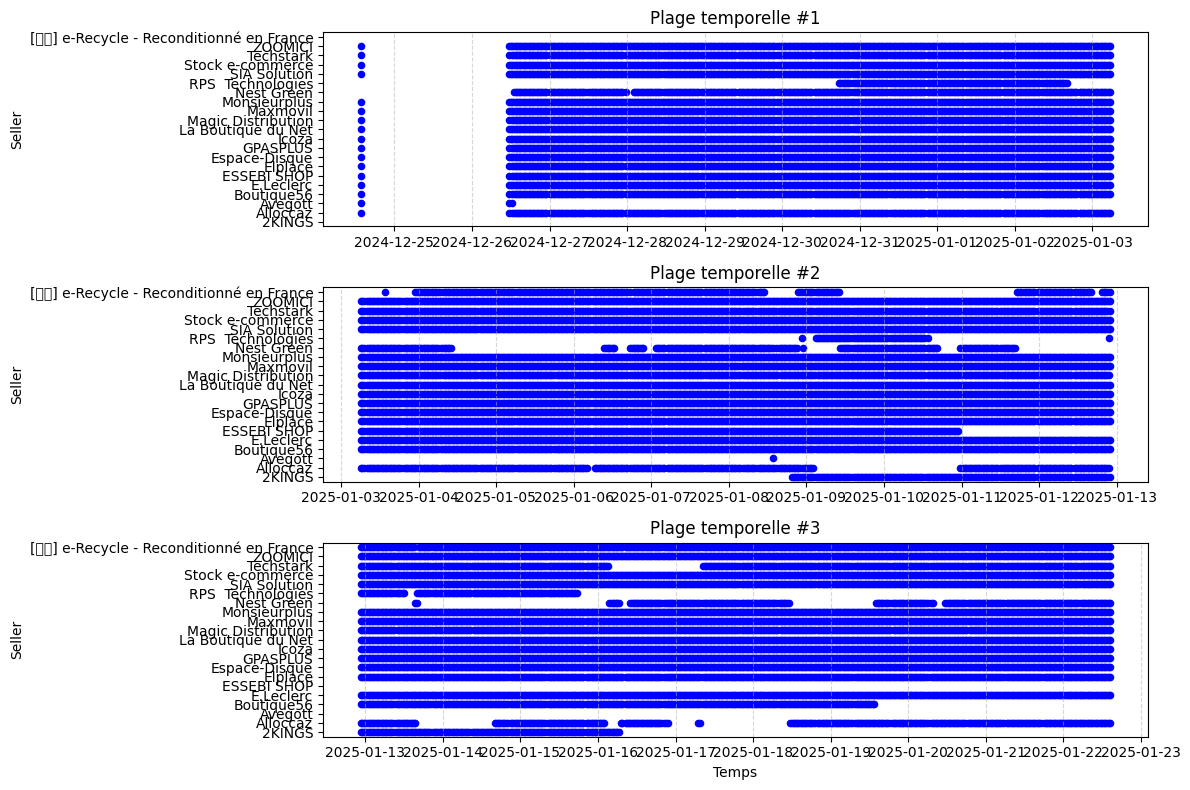

In [10]:
import matplotlib.pyplot as plt

# Conversion de la colonne Timestamp en datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# On retire les lignes où Timestamp ou Seller est manquant
df = df.dropna(subset=["Timestamp", "Seller"])

# Extraction des bornes min et max de nos timestamps
start_time = df["Timestamp"].min()
end_time = df["Timestamp"].max()

# 2) Construction d'une échelle de temps toutes les 30 minutes
time_range = pd.date_range(start=start_time, end=end_time, freq="30T")

# 3) Liste des Sellers, triés pour avoir un ordre stable
sellers = sorted(df["Seller"].unique())

# Par souci de cohérence, on va indexer nos Sellers de 0 à len(sellers)-1
seller_to_index = {seller: i for i, seller in enumerate(sellers)}

# 4) Découpage de la plage temporelle en 3 parties pour 3 subplots
n = len(time_range)
split1 = n // 3
split2 = 2 * n // 3

time_range_1 = time_range[:split1]
time_range_2 = time_range[split1:split2]
time_range_3 = time_range[split2:]

time_ranges = [time_range_1, time_range_2, time_range_3]

# 5) Préparation de la figure avec 3 subplots (axes) verticalement
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

# Optionnel : On peut définir une tolérance 
# pour considérer qu'un Timestamp "tombe" à l'instant t 
# (p.ex. ±15 minutes). 
# Ici, on illustre une approche stricte où l'on veut un Timestamp 
# réellement "dans la demi-heure" — On peut adapter si besoin.
tolerance = pd.Timedelta("15min")

# Pour accélérer les recherches, on stocke les timestamps distincts
# de chaque Seller dans un dictionnaire (on trie pour plus de clarté).
seller_timestamps = {}
for seller in sellers:
    times_for_seller = df.loc[df["Seller"] == seller, "Timestamp"].drop_duplicates().sort_values()
    seller_timestamps[seller] = times_for_seller

for i, (ax, sub_time_range) in enumerate(zip(axes, time_ranges)):
    
    # Pour chaque seller, on détermine les instants (dans sub_time_range) 
    # pour lesquels on a au moins un timestamp "assez proche" (tolérance)
    for seller in sellers:
        # Liste (ou array) des timestamps réels de ce Seller
        real_times = seller_timestamps[seller]
        
        # On construit la liste des instants (dans sub_time_range) où on a un point
        presence_times = []
        
        for t in sub_time_range:
            # Vérifie s’il existe un timestamp réel dans [t - tol, t + tol]
            # (si on veut être strict, on vérifierait l'égalité exacte, 
            #  mais souvent les instants ne tombent pas pile sur 30 min.)
            mask = (real_times >= (t - tolerance)) & (real_times <= (t + tolerance))
            if mask.any():
                presence_times.append(t)
        
        # Si on a trouvé des instants où la collecte existe pour ce Seller,
        # on fait un scatter sur la ligne y = seller_index
        if presence_times:
            y = seller_to_index[seller]
            ax.scatter(presence_times, [y]*len(presence_times), marker='o', color='blue', s=20)
    
    # Mise en forme du subplot
    ax.set_title(f"Plage temporelle #{i+1}")
    ax.set_ylabel("Seller")
    ax.set_yticks(range(len(sellers)))
    ax.set_yticklabels(sellers)
    ax.set_ylim([-0.5, len(sellers)-0.5])  # Laisser un peu de marge en haut et en bas
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# On met un label commun pour l'axe X seulement sur le dernier ou globalement
axes[-1].set_xlabel("Temps")

plt.tight_layout()
plt.show()


C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


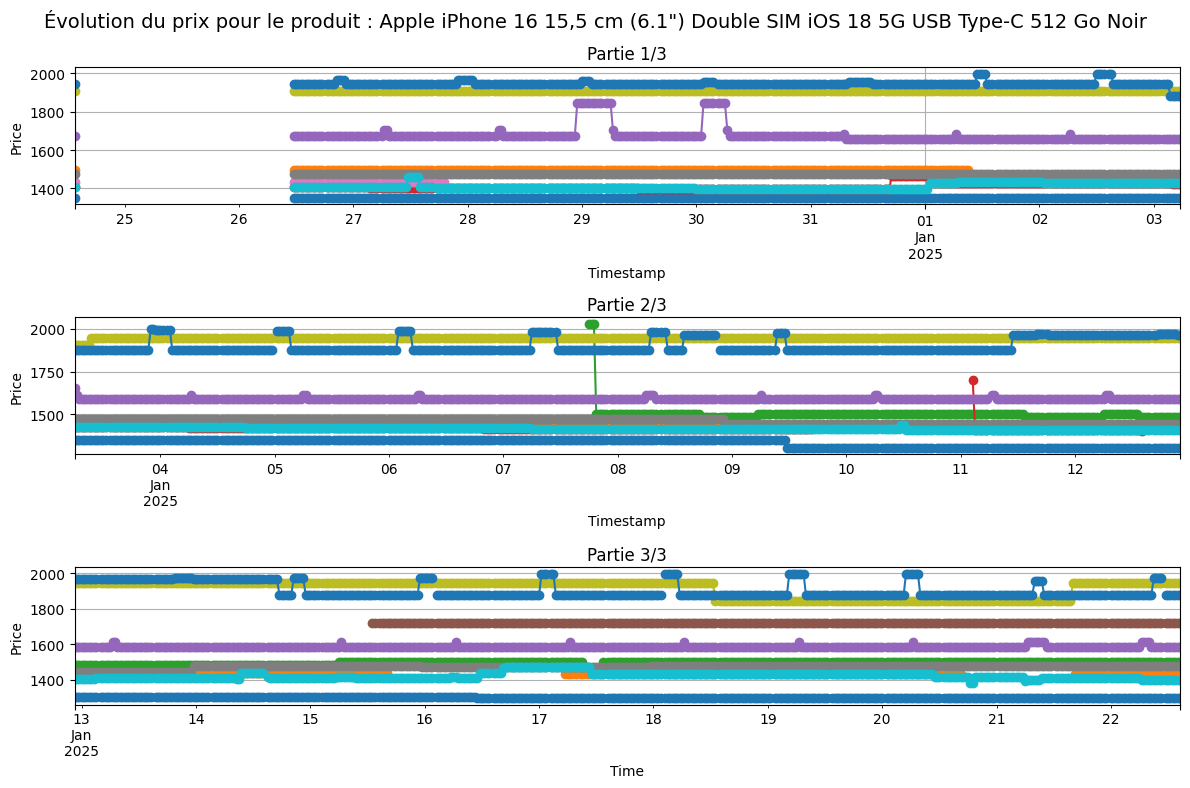

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


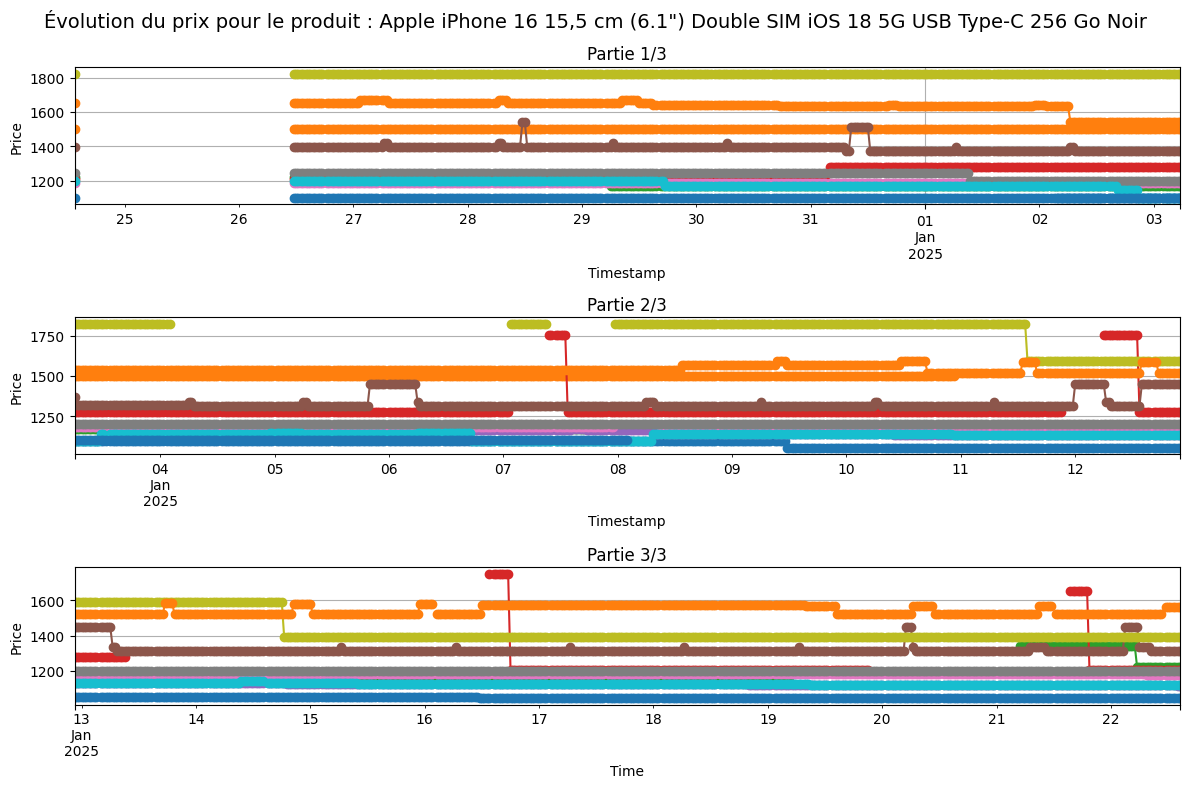

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


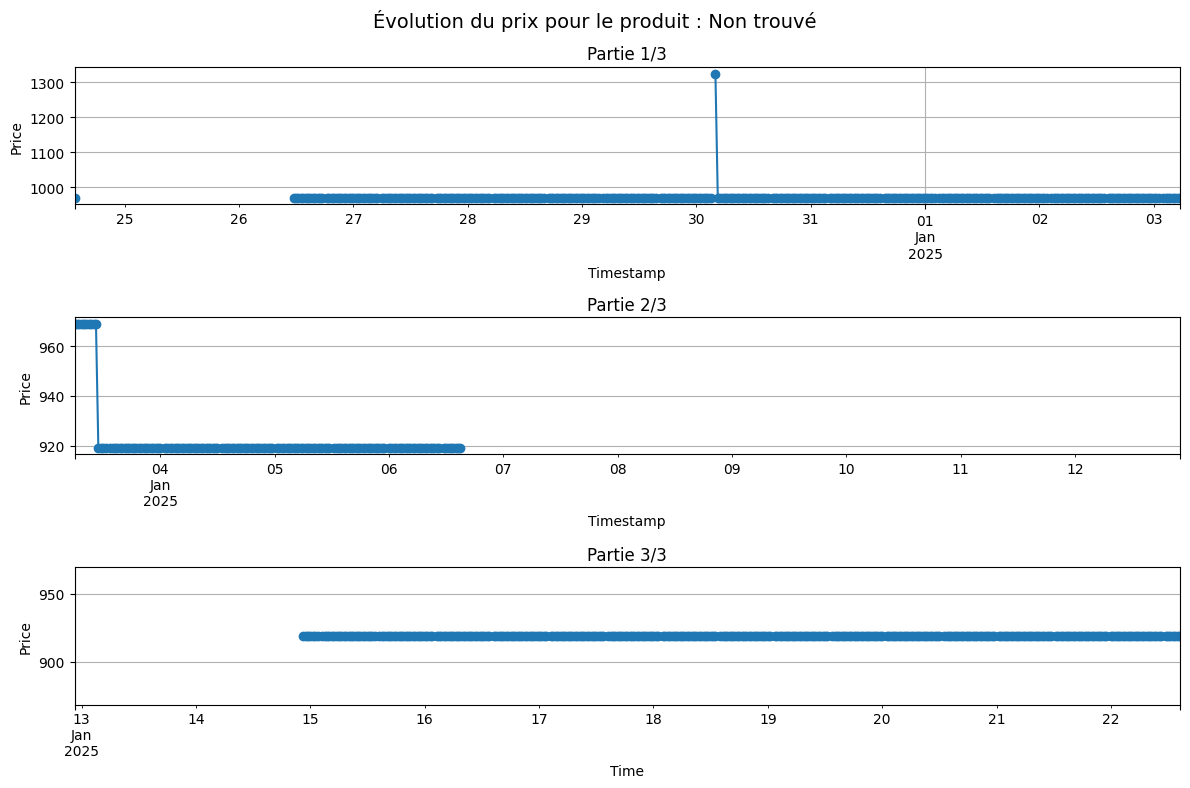

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


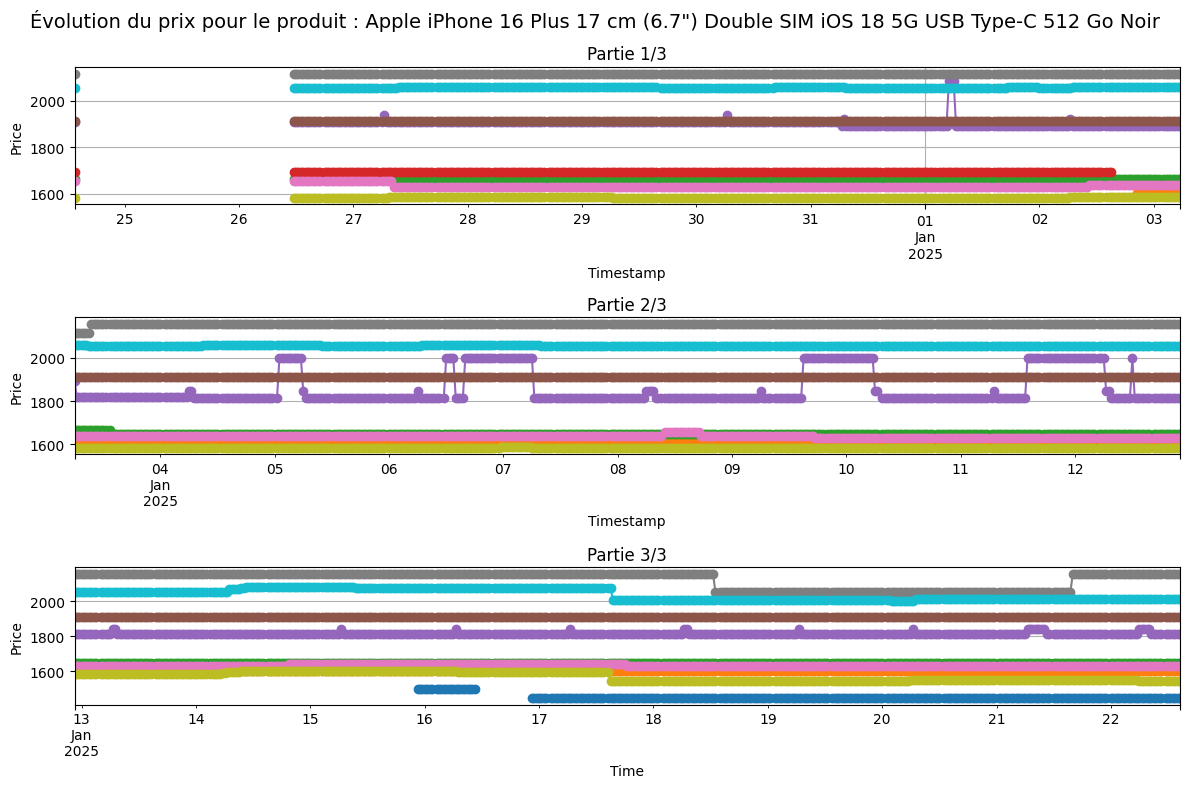

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


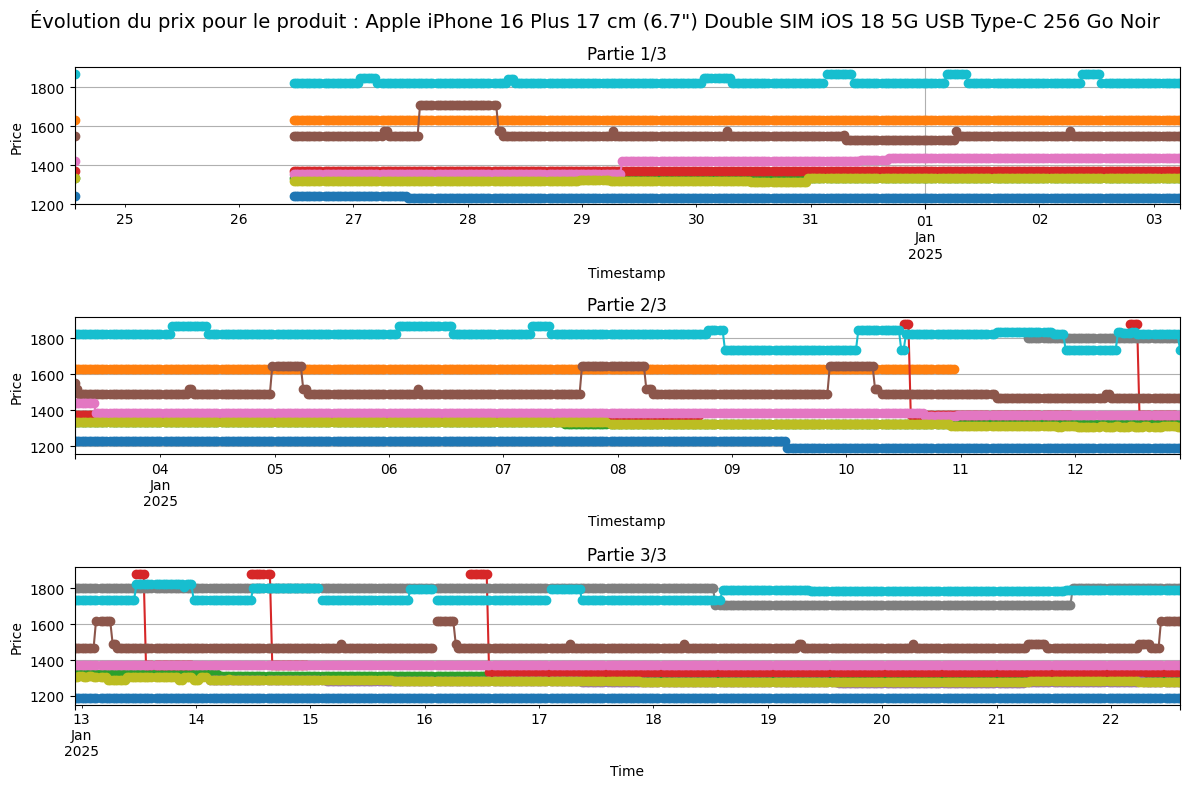

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


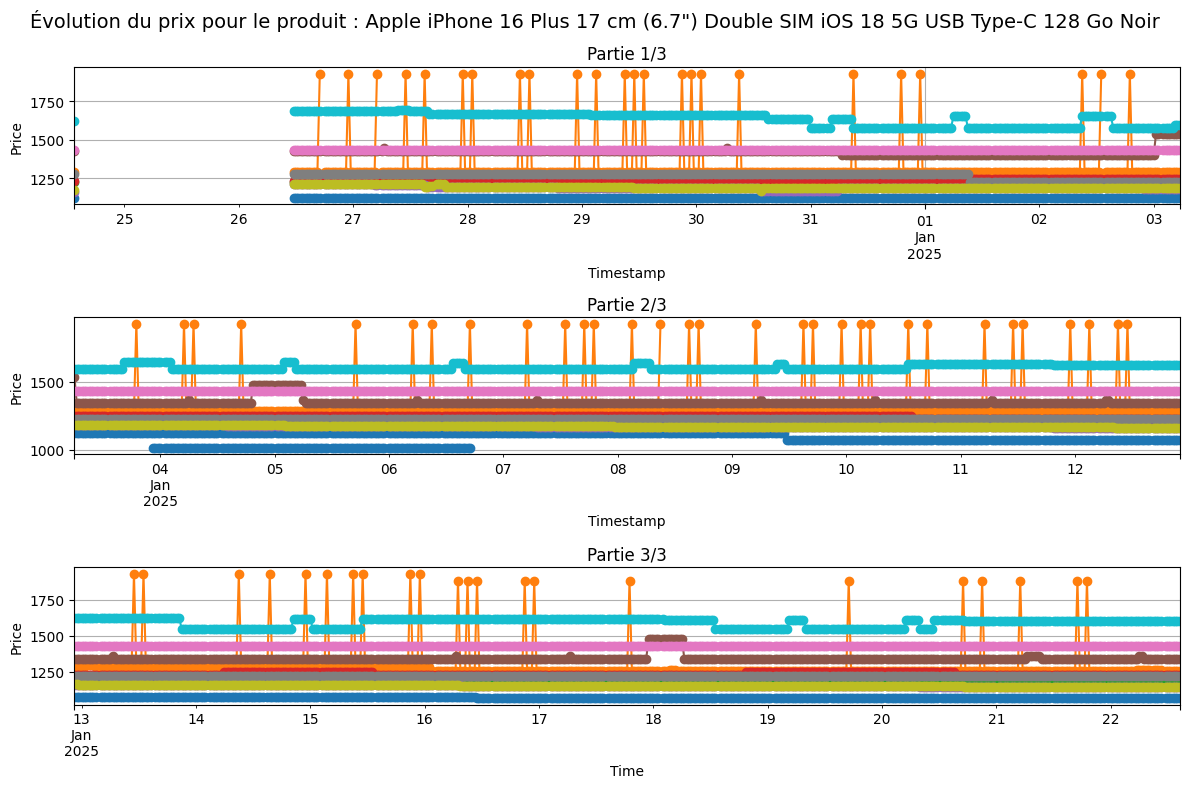

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


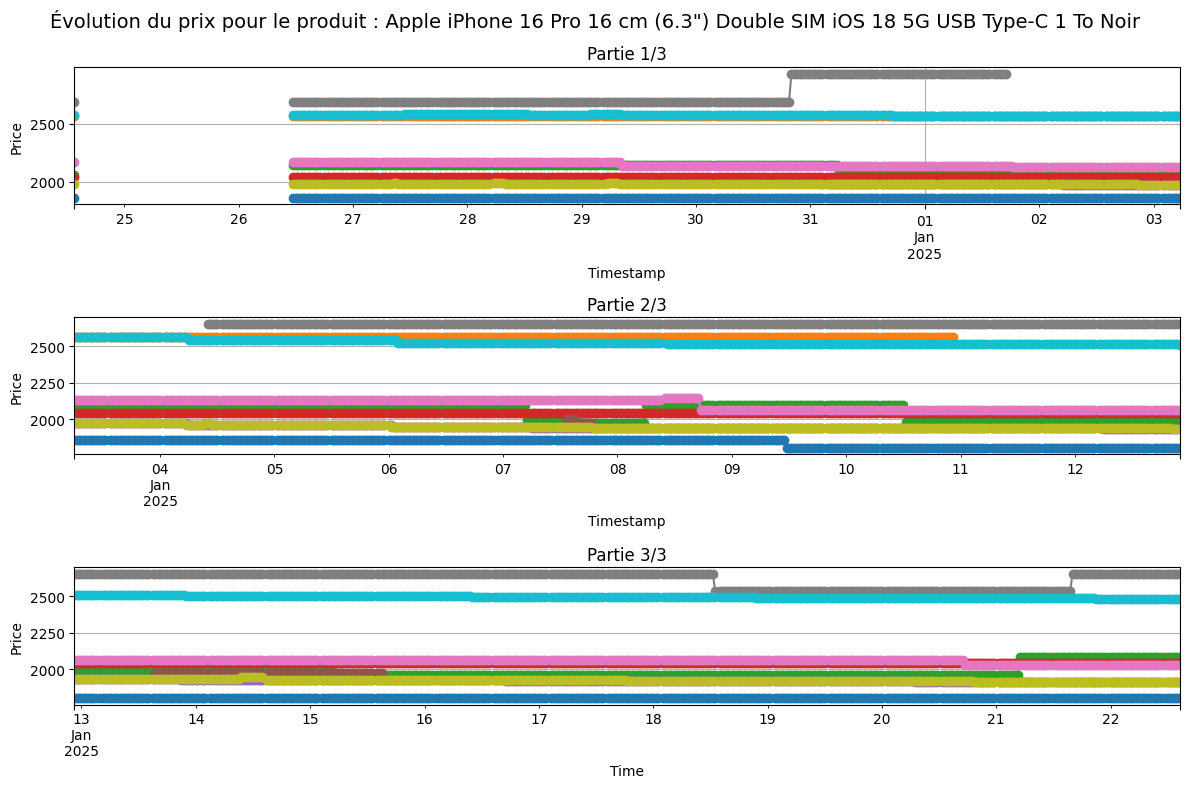

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


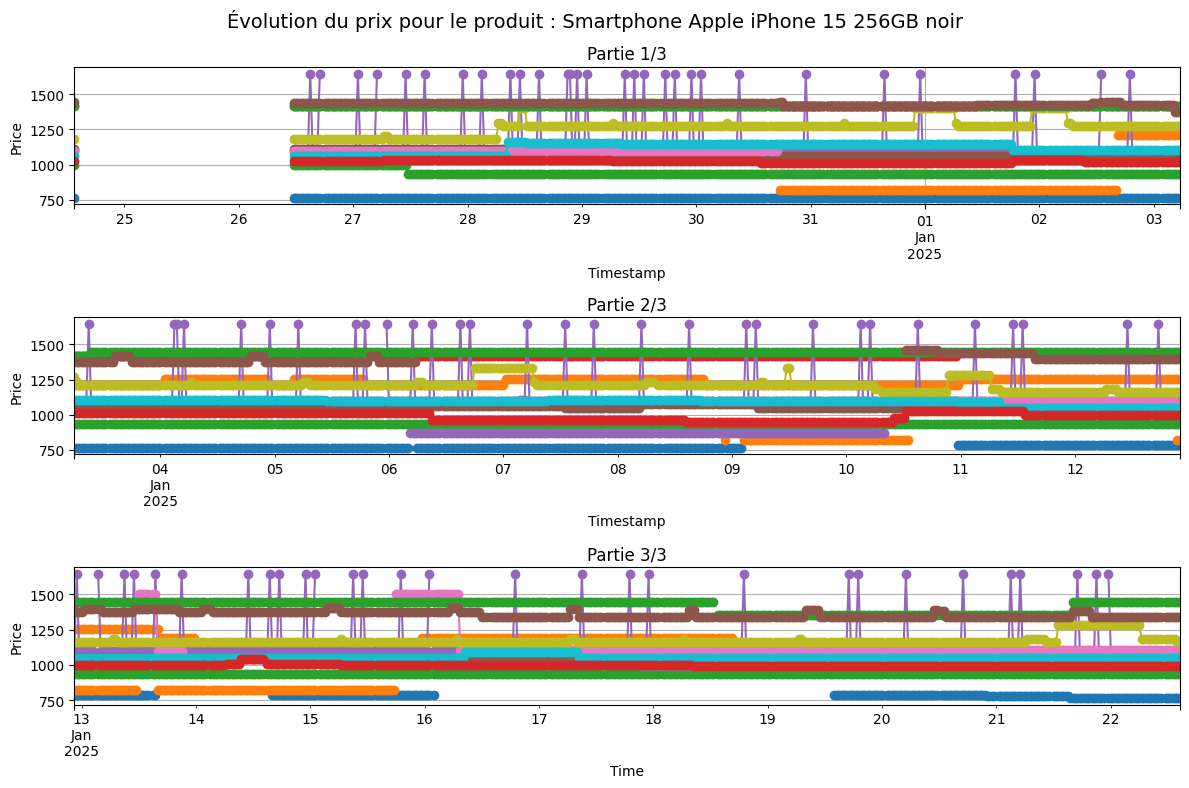

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


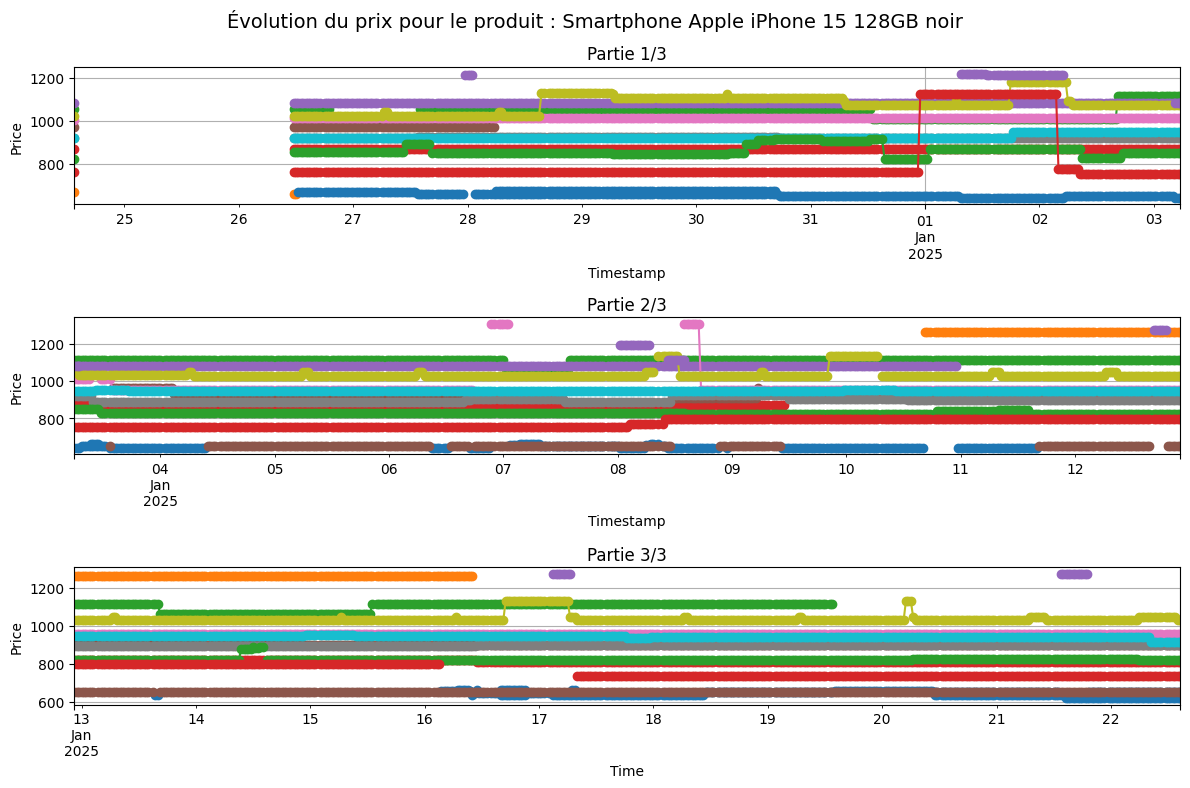

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


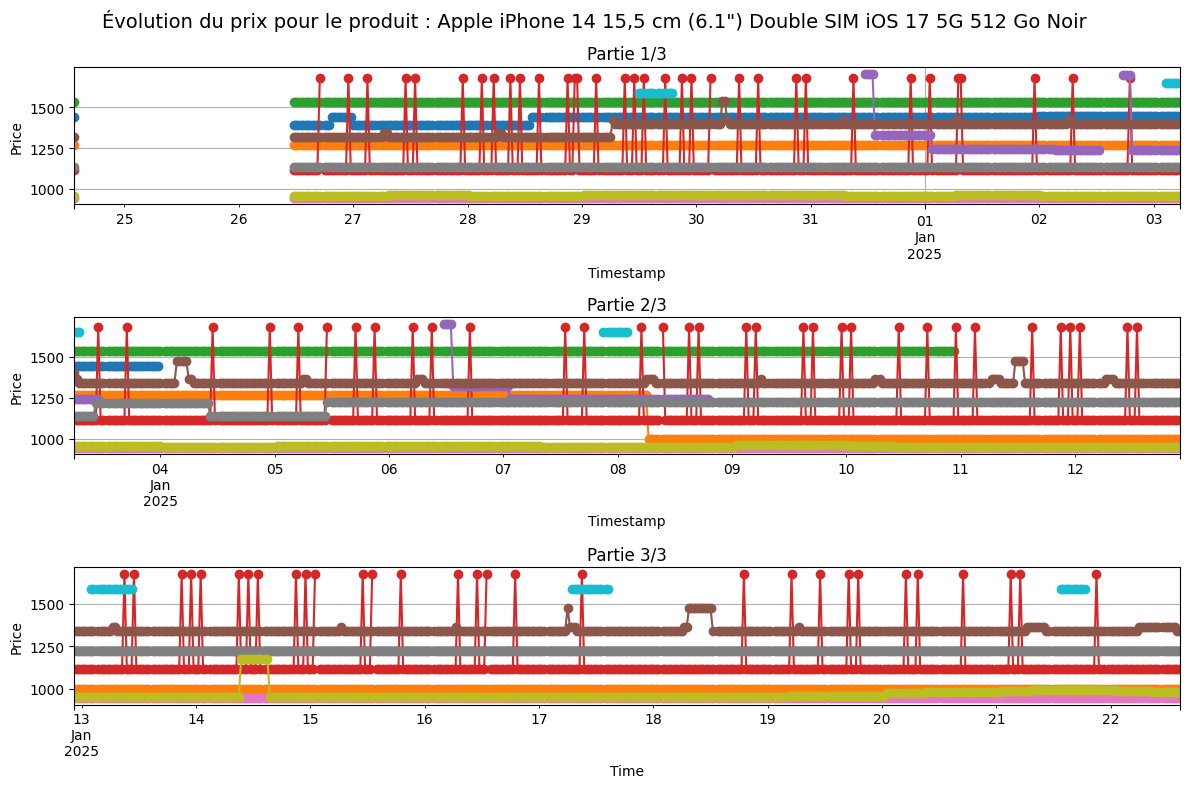

C:\Users\zoero\AppData\Local\Temp\ipykernel_23916\2755577258.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot_df_30min = pivot_df.resample("30T").mean()


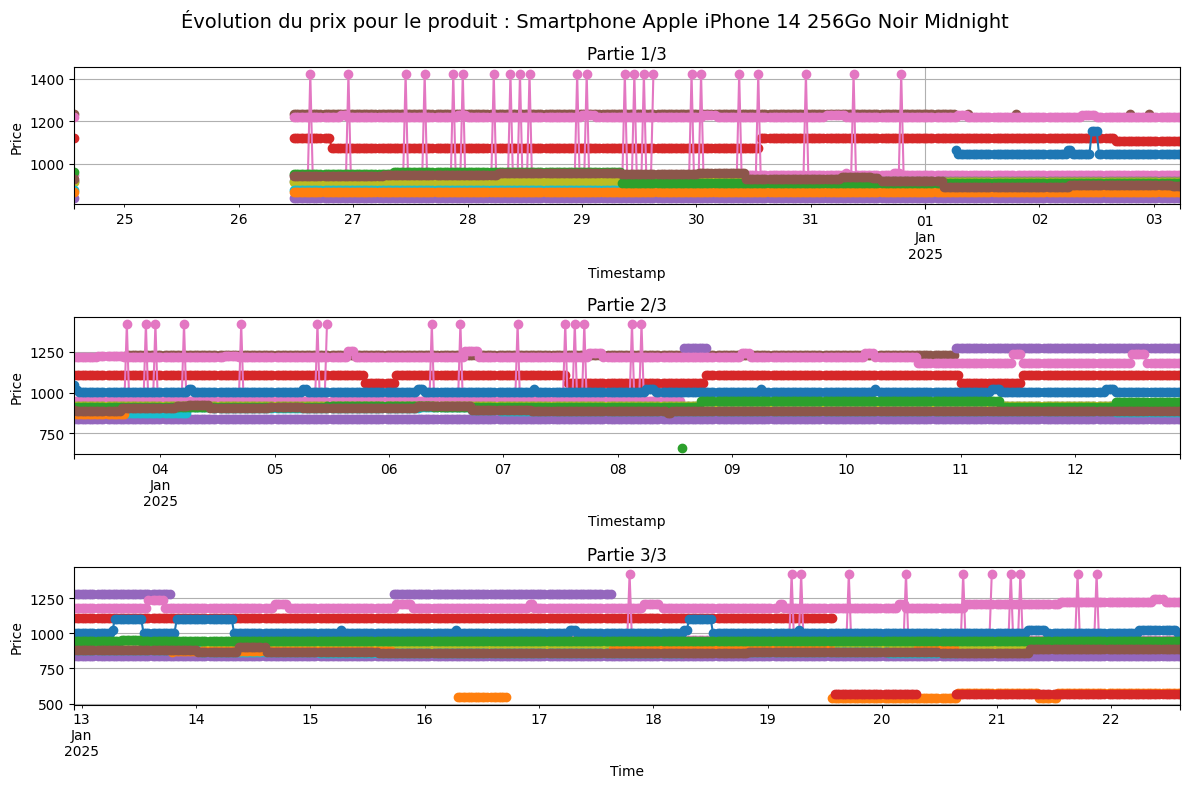

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import math


# Retrait des lignes incomplètes
df = df.dropna(subset=["Timestamp", "Seller", "Price", "Product Name"])


# ---------------------------------------------------------------------
# 2) LISTE DES PRODUITS
# ---------------------------------------------------------------------
product_names = df["Product Name"].dropna().unique()

# ---------------------------------------------------------------------
# 3) BOUCLE SUR CHAQUE PRODUCT NAME
# ---------------------------------------------------------------------
for product in product_names:
    
    # Filtrer le DataFrame pour le produit courant
    df_product = df[df["Product Name"] == product]
    
    if df_product.empty:
        continue  # Si pas de données pour ce produit (par sécurité)
    
    # -----------------------------------------------------------------
    # 3.1) CRÉER LE TABLEAU LARGE (PIVOT) : index=Timestamp, cols=Seller, val=Price
    # -----------------------------------------------------------------
    pivot_df = df_product.pivot_table(
        index="Timestamp",
        columns="Seller",
        values="Price",
        aggfunc="mean"  # moyenne si plusieurs valeurs pour (Timestamp, Seller)
    )
    
    # -----------------------------------------------------------------
    # 3.2) RÉSAMPLE À UN PAS DE 30 MINUTES
    # -----------------------------------------------------------------
    # On prend la moyenne sur chaque intervalle de 30 min
    pivot_df_30min = pivot_df.resample("30T").mean()
    
    # S'il n'y a qu'un seul timestamp, le resample peut être vide ou insignifiant
    if pivot_df_30min.empty:
        continue
    
    # -----------------------------------------------------------------
    # 3.3) DÉCOUPAGE DE LA PLAGE TEMPORELLE EN 3 PARTIES
    # -----------------------------------------------------------------
    n = len(pivot_df_30min.index)
    if n <= 1:
        # Pas assez de points pour faire 3 sous-plots
        # On peut décider d'afficher tout en un seul si on veut
        # Ici, on saute l'affichage
        continue
    
    split1 = n // 3
    split2 = 2 * n // 3
    
    df_part1 = pivot_df_30min.iloc[:split1]
    df_part2 = pivot_df_30min.iloc[split1:split2]
    df_part3 = pivot_df_30min.iloc[split2:]
    
    # -----------------------------------------------------------------
    # 3.4) AFFICHAGE EN 3 SOUS-GRAPHIQUES
    # -----------------------------------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)
    fig.suptitle(f"Évolution du prix pour le produit : {product}", fontsize=14)
    
    # Subplot 1
    df_part1.plot(ax=axes[0], marker='o', legend=False)  
    axes[0].set_title("Partie 1/3")
    axes[0].set_ylabel("Price")
    axes[0].grid(True)

    # Subplot 2
    df_part2.plot(ax=axes[1], marker='o', legend=False)
    axes[1].set_title("Partie 2/3")
    axes[1].set_ylabel("Price")
    axes[1].grid(True)

    # Subplot 3
    df_part3.plot(ax=axes[2], marker='o', legend=False)
    axes[2].set_title("Partie 3/3")
    axes[2].set_ylabel("Price")
    axes[2].set_xlabel("Time")
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()


Uniquement sur la période de Noel

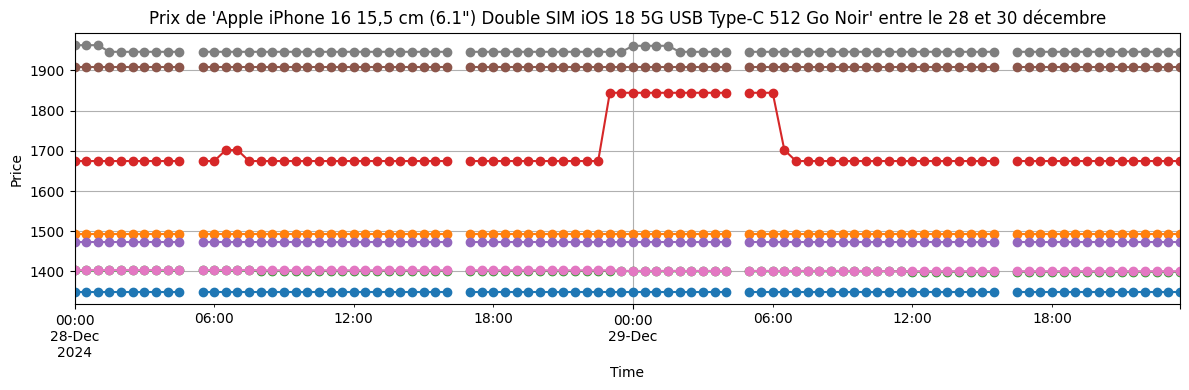

Graphique affiché pour : Apple iPhone 16 15,5 cm (6.1") Double SIM iOS 18 5G USB Type-C 512 Go Noir


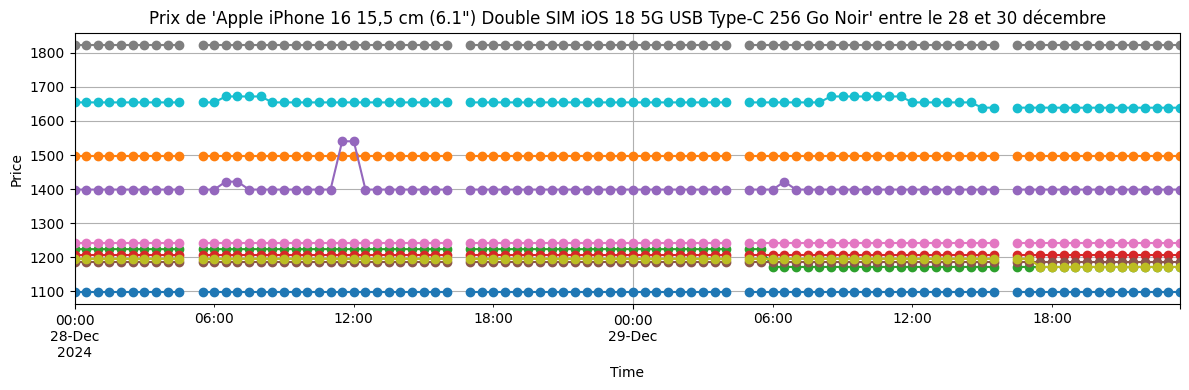

Graphique affiché pour : Apple iPhone 16 15,5 cm (6.1") Double SIM iOS 18 5G USB Type-C 256 Go Noir


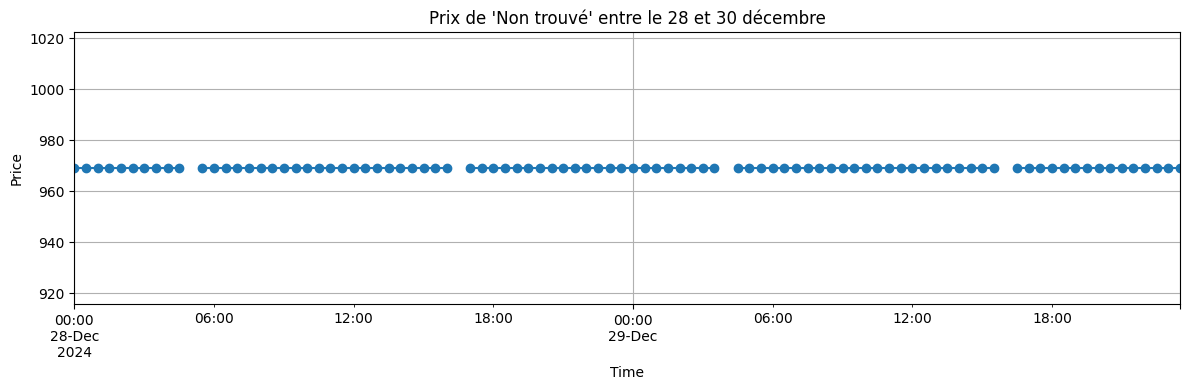

Graphique affiché pour : Non trouvé


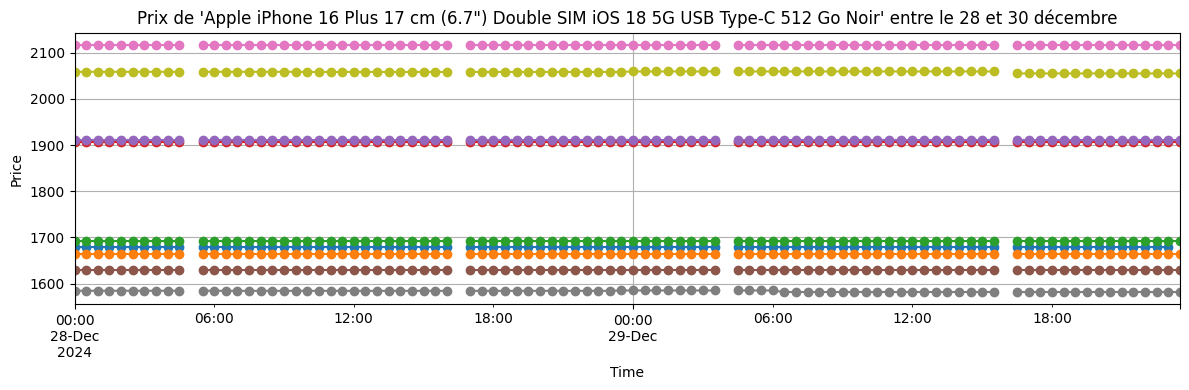

Graphique affiché pour : Apple iPhone 16 Plus 17 cm (6.7") Double SIM iOS 18 5G USB Type-C 512 Go Noir


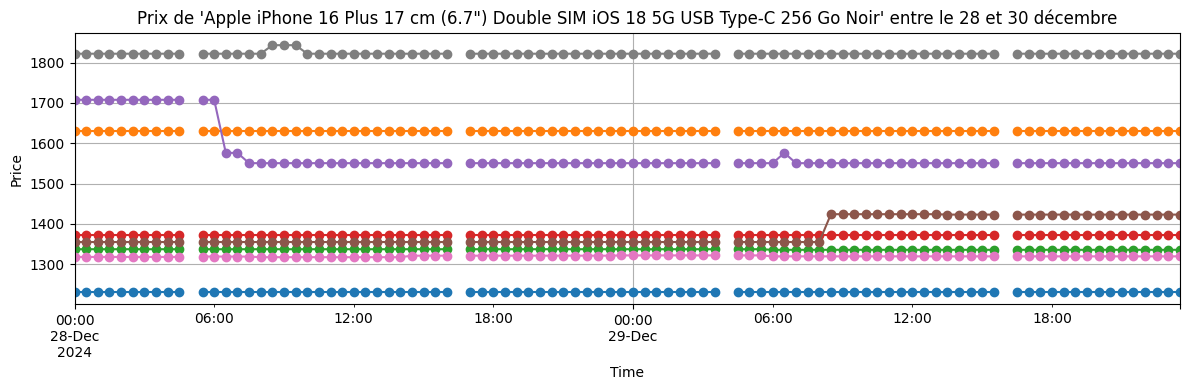

Graphique affiché pour : Apple iPhone 16 Plus 17 cm (6.7") Double SIM iOS 18 5G USB Type-C 256 Go Noir


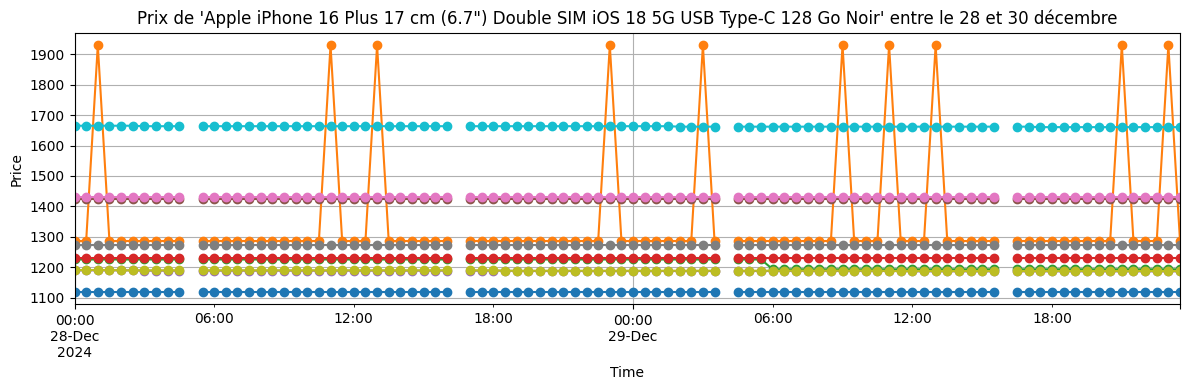

Graphique affiché pour : Apple iPhone 16 Plus 17 cm (6.7") Double SIM iOS 18 5G USB Type-C 128 Go Noir


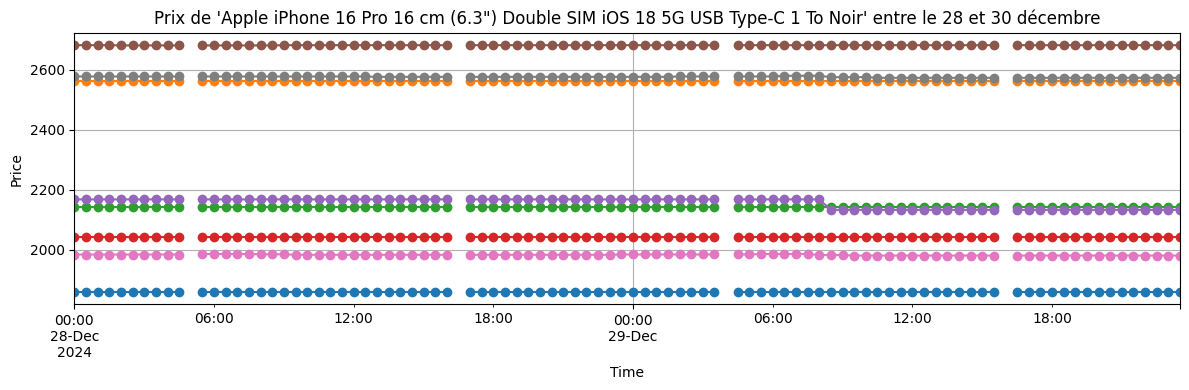

Graphique affiché pour : Apple iPhone 16 Pro 16 cm (6.3") Double SIM iOS 18 5G USB Type-C 1 To Noir


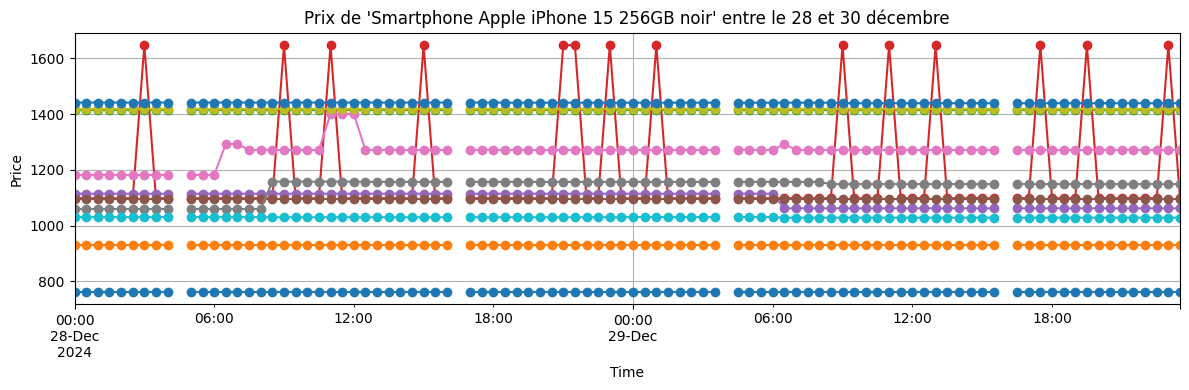

Graphique affiché pour : Smartphone Apple iPhone 15 256GB noir


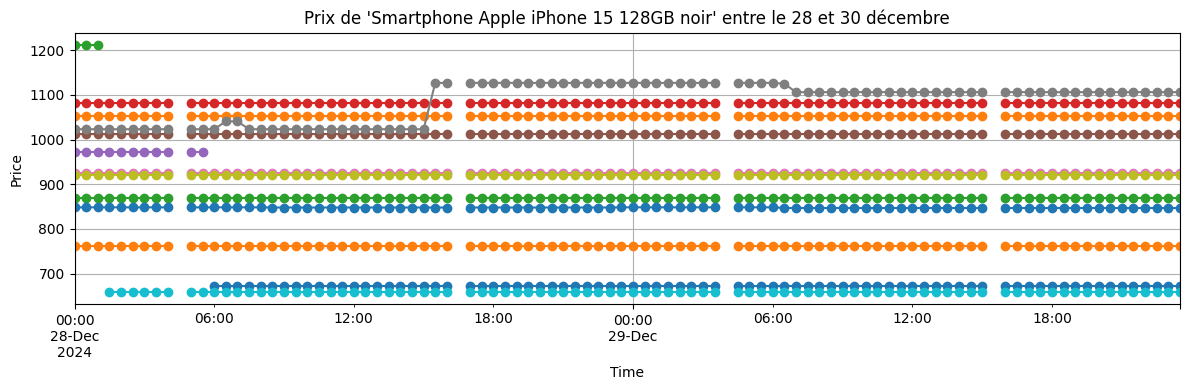

Graphique affiché pour : Smartphone Apple iPhone 15 128GB noir


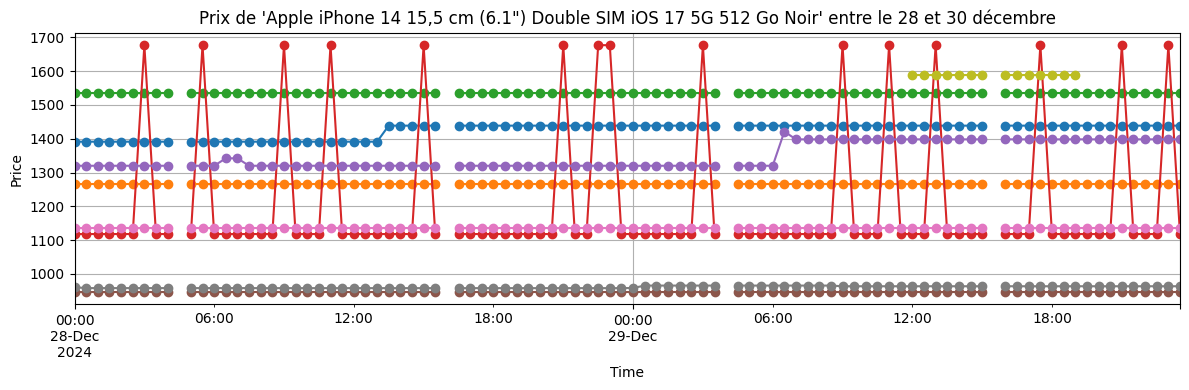

Graphique affiché pour : Apple iPhone 14 15,5 cm (6.1") Double SIM iOS 17 5G 512 Go Noir


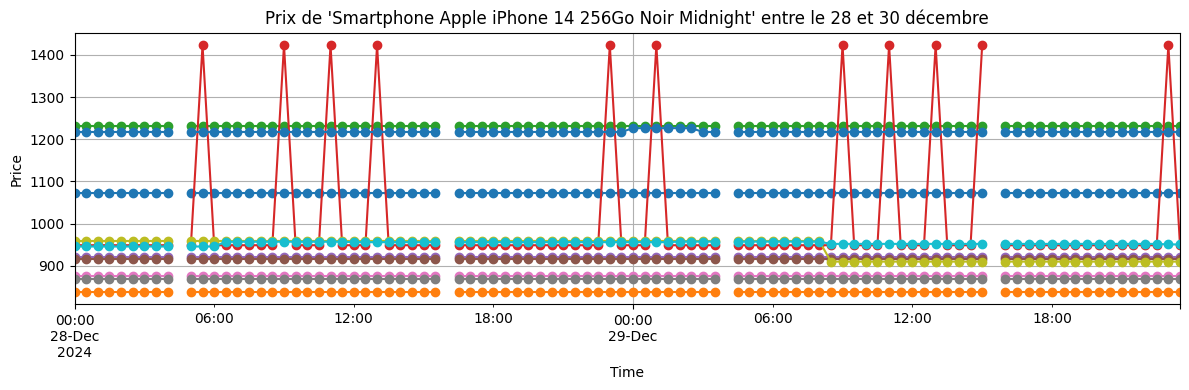

Graphique affiché pour : Smartphone Apple iPhone 14 256Go Noir Midnight


In [10]:
start_zoom = "2024-12-28"
end_zoom   = "2024-12-30"

df_zoom = df[(df["Timestamp"] >= start_zoom) & (df["Timestamp"] <= end_zoom)]

if df_zoom.empty:
    print("Aucune donnée entre le 15 et le 25 décembre pour ce fichier.")
    # On peut stopper ou continuer. Ici, on arrête :
    exit()

# ---------------------------------------------------------------------
# 3) Liste des produits
# ---------------------------------------------------------------------
product_names = df_zoom["Product Name"].dropna().unique()

# ---------------------------------------------------------------------
# 4) Pour chaque produit, on trace une seule série temporelle (pas de découpage)
# ---------------------------------------------------------------------
for product in product_names:
    # Filtrer pour le produit courant
    df_product = df_zoom[df_zoom["Product Name"] == product]
    if df_product.empty:
        continue
    
    # Pivot: index=Timestamp, colonnes=Seller, valeurs=Price
    pivot_df = df_product.pivot_table(
        index="Timestamp",
        columns="Seller",
        values="Price",
        aggfunc="mean"  # moyenne si plusieurs valeurs pour (Timestamp, Seller)
    )
    
    # Resample toutes les 30 minutes
    pivot_df_30min = pivot_df.resample("30min").mean()
    
    if pivot_df_30min.empty:
        continue  # pas de données après rééchantillonnage
    
    # Affichage d'une seule série temporelle (une courbe par Seller)
    fig, ax = plt.subplots(figsize=(12, 4))
    pivot_df_30min.plot(ax=ax, marker='o', legend=False)
    
    ax.set_title(f"Prix de '{product}' entre le 28 et 30 décembre")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    print("Graphique affiché pour :", product)